### First let's import everything we will need :

In [1]:
# My personnal helper classes to get the data :
from data_reader.data_reader import DataReader
from data_reader.helpers import locations, mean_diploma, mean_age, socio_pro_class

# A few standard libraries :
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(9,6.5)})

# Now describe & create all the datasets - with some reminders from the 'single dataset' notebooks.

### 1) The referendum data

This is the reason for our study, it contains all the results from the Referendum per town, giving numbers of suscribed voters, blank votes, abstention and votes for each proposition.

The **INSEE code has to be built back from Dept & City codes**. Keep in mind building it is necessary to have an unique identifier. Throughout this notebook use it as the DataFrame index.

This is the only dataset that also contains TOMs and French from abroad dataset. So far we keep all of it for the first few plots.

In total it reports the results from 36791 towns. 

Paris, Marseille and Lyon are reported as only one entry each. We will force the other datasets to use this too.

In [2]:
referendum = DataReader(
    path=locations("referendum"),
    insee_code=('Code du département','Code de la commune'),
    drop_domtom=False
).content()

I keep the reader to easily remove DomToms later.
Let's augment this with the official definition of abstention.

In [3]:
referendum["Abstention Totale"] = referendum["Abstentions"]+referendum["Blancs et nuls"]

### 2) The diploma data

The first dataframe only reads a simple dataset that allows to translate between the official nomenclature and clearer information (age, diploma, sex). The second one is the one of interest.

The **second dataset is the one we want to look into : it contains all the information on the education level of each town**, given as the number of people that achieved to graduate at each level. It is also split by gender and in two age class (16-24, >= 25)

There are **20 entries for Paris, one per Arrondissement. We sum all of their entries** into one. 
The survey reports over several years, we only look at 2012 (closest to the referendum). Due to town appearing or merging, there are some rows with no values - they are removed.

The impact of not having 2013 is not significant : less than 10 (small) towns aren't found in 2013's Referendum.

This **data is augmented computing a mean diploma level** per town. This level is computed from the age at which someone who didn't double would get a given diploma. It is set at 6 for people without diploma, and goes to 24. (There is some arbitrary in choice, but it may be better than using the median graduation age that could bake into it socio-economical problems, with people deciding to stop/come back to their studies for various reasons)

DOMs here (and in all INSEE data) have Dept code 97, different from the convention in the Referendum data ('Z*').

In [4]:
helper_df=DataReader(
    path=locations('diploma_helper'),
    sheet_name='Sheet1',
    sep=',',
    force_index='Unnamed: 0'
).content()

In [5]:
diplomas=DataReader(
    path=locations("diplomes"), 
    sheet_name='COM_2012',
    skiprows=16, 
    insee_code=('dr','cr'),
    drop_domtom=True,
    rm_nan=True, #Values sometime not filled due to (dis)appearing towns through the survey
    arrondissement_handling="Merge"
).content()

In [6]:
diplomas=diplomas.assign(MeanDiploma=lambda x: mean_diploma(x,helper_df))

### 3) The Recensement

This gives the number of inhabitants per town, further split per gender and age group. It also split wrt where people lived an year before, and socio-professional categories.

There are caveats to keep in mind : below 200 inhabitants, it should not be considered accurate and below 2000 the information socio-professional categories should not be used. This also holds for 'secondary information' derived from this recensement, i.e. diploma and revenue.

This dataset is augmented computing the mean age per town.

This provide information on the DOMs, not TOMs/Frenchs abroad.

In [7]:
recensement=DataReader(
    path=locations("recensement"), 
    sheet_name='COM_2013',
    drop_domtom=True,
    insee_code=('CODGEO',),
    skiprows=5 # Row nb. 6 will be the columns names
).content()

In [8]:
recensement=recensement.assign(MeanAge=mean_age)

### 4) Revenue data

This gives the **distribution of income in each town, for metropolitan france only**.
It includes the number of households, the median income, the poverty rate, the fraction of taxable households and the wage gap.

No information is given below 50 households and only median income & number of households between 50-1000.

For Paris,Marseille,Lyon only keep information at town level (also available per Arrondissement)

In [9]:
revenus=DataReader(
    path=locations("revenus"), 
    sheet_name='COM',
    skiprows=5, # Row nb. 6 will be the columns names
    insee_code=('CODGEO',),
    drop_domtom=True,
    arrondissement_handling="Delete"
).content()

### 5) Geographical data

**Contains the data of all French cities boundaries**. However it is from 2022 (past ones are removed), which means there is a fair number of towns that (dis)appeared.

820 towns have different names in this dataset and the Recensement, but matching INSEE codes. Most cases it seems to be only typing differences, but there are also towns merging and keeping one code.

18 towns are only found in the geographical data, it's impossible to know how many people this represents.

**1704 towns are seen only in the recensement, which makes 968976 people**. It is likely most of them would be found in town mergers, but checking this explicitely would require a deeper study. As it is ~1.5% of the population only, we keep it this way.

In [10]:
geo_data=DataReader(
    path=locations("geodata"),
    drop_domtom=True,
    insee_code=('insee',)
).content()
geo_data = geo_data.to_crs('EPSG:3395') #Mercator projection

# I - Which proposition won :

We begin by computing the results at a national level, summing the votes over all towns.
Then the actual plot is done.

In [ ]:
national=referendum[ ["Inscrits","Abstentions","Blancs et nuls","Choix A","Choix B"] ].sum()
national["Abstention Totale"] = national["Abstentions"]+national["Blancs et nuls"]
national = 100*national/national["Inscrits"]

[Text(0, 0.5, '% of registered voters'),
 Text(0.5, 0, 'Official voting categories'),
 Text(0.5, 1.0, 'Fraction of abstention and of votes received by each option')]

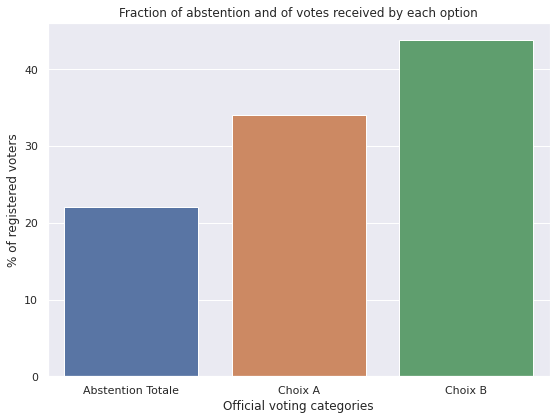

In [11]:
x=["Abstention Totale","Choix A","Choix B"]
y=[national[i] for i in x]
ax=sns.barplot(x=x,y=y)
ax.set(ylabel="% of registered voters",
       xlabel="Official voting categories",
       title="Fraction of abstention and of votes received by each option")

So quite clearly, **Choice B was selected** by the people.

Let's now try to find out whether a specific part of the population favoured it.

In the following we will restrict all the analysis to the Metropole & Corsica, as not all data is available for DomToms.

In [12]:
referendum = DataReader(
    path=locations("referendum"),
    insee_code=('Code du département','Code de la commune'),
    drop_domtom=True
).content()

referendum["Abstention Totale"] = referendum["Abstentions"]+referendum["Blancs et nuls"]
for id in ["Abstention Totale","Choix A","Choix B"]:
    referendum[f"Fraction {id}"] = 100*referendum[id]/referendum["Inscrits"]

# IMPORTANT NOTES :

In the following only Metropolitan France (inc. Corsica) will be considered, as not all data is available in DomToms.

I will also remove cities with less than 200 inhabitants (`P13_POP`) from the analysis, as the Recensement claim they will not be accurate - except for maps. 

# II - Geographical distribution of the vote :

Let's try to check the geographical distribution of the french population first, then of the vote. 
Finding a correlation with urban areas might give us insigths

The 'big city' threshold at 60k is a bit arbitrary, but gave the best mapping of urban areas

In [13]:
all_data = gpd.GeoDataFrame(pd.concat([revenus,diplomas,referendum,recensement,geo_data],axis=1))
above200 = all_data.loc[all_data['P13_POP'] > 200]
big_cities=all_data[all_data['P13_POP']>60000].geometry

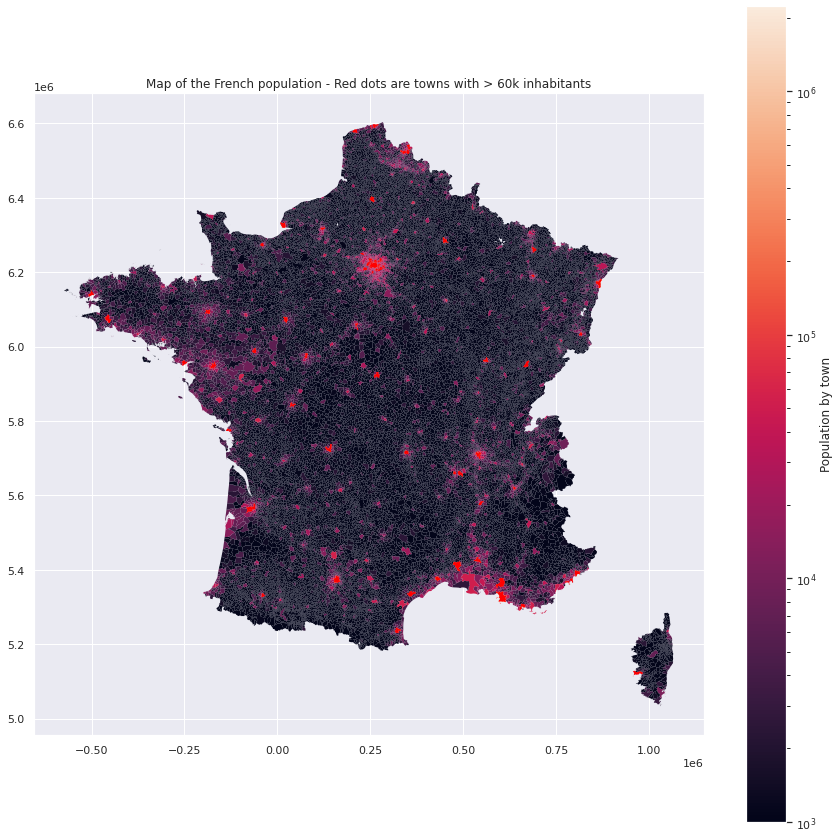

In [57]:
ax = all_data.plot(
    column='P13_POP',figsize=(15,15),edgecolor='none',legend=True,
    norm=matplotlib.colors.LogNorm(vmin=1000, vmax=all_data.P13_POP.max()),
    legend_kwds={'label': "Population by town"}
) 
big_cities.plot(color='red',ax=ax,markersize=5,marker='o',edgecolor='none')
plt.title("Map of the French population - Red dots are towns with > 60k inhabitants")
plt.show()

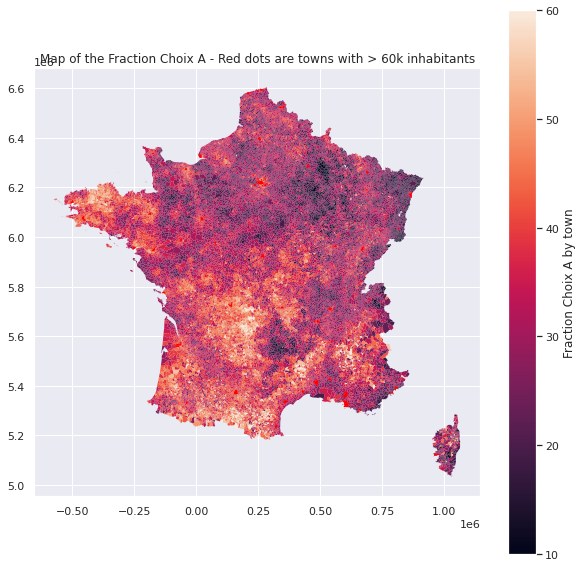

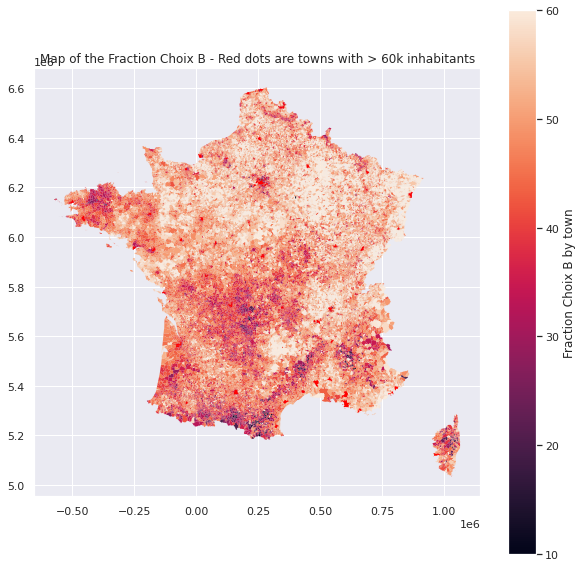

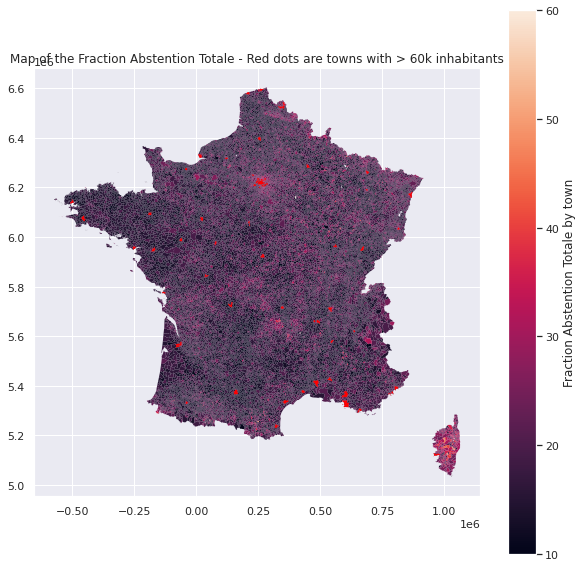

In [58]:
names=[f'Fraction {id}' for id in ['Choix A','Choix B','Abstention Totale']]

for id in names:
    ax = all_data.plot(
        column=id,figsize=(10,10),edgecolor='none',legend=True,
        legend_kwds={'label': f"{id} by town"},
        vmin=10,vmax=60
    ) 
    big_cities.plot(color='red',ax=ax,markersize=5,marker='o',edgecolor='none')
    plt.title(f"Map of the {id} - Red dots are towns with > 60k inhabitants")
    plt.show()

So there is no clear link with rural/urban areas, however I'll run it again without the big cities to get a better idea of the Parisian region.

There is some trend Sout West/North East, with the latter being much more favourable to option B.

Hidden cells below give the same maps, but without the markers for the big cities. It shows that Parisian region seems to favor option A, and abstain more. It is the most defavourable to Option B.

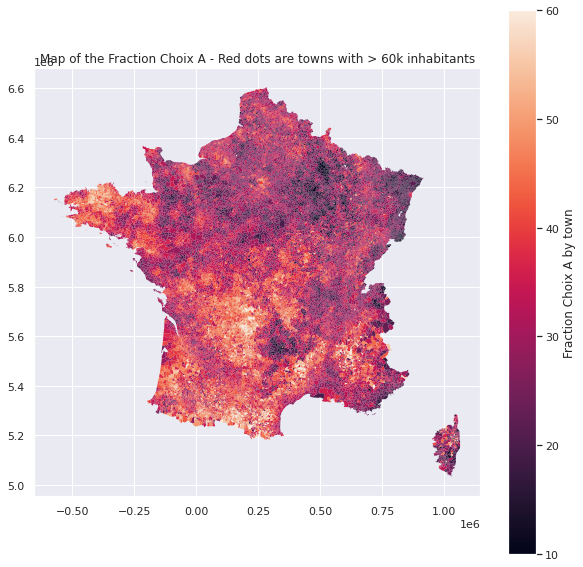

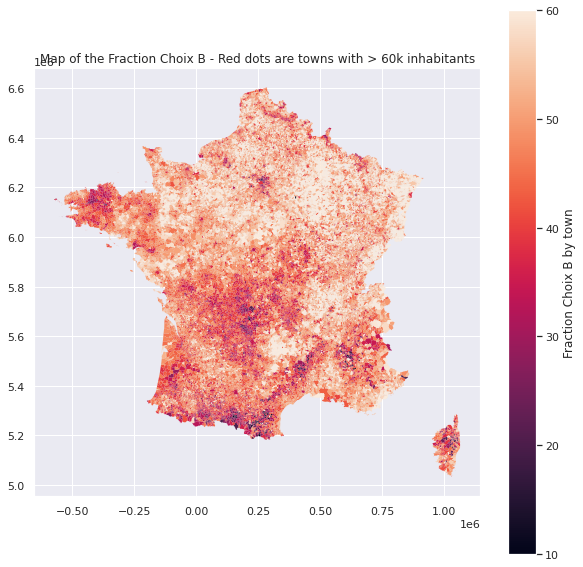

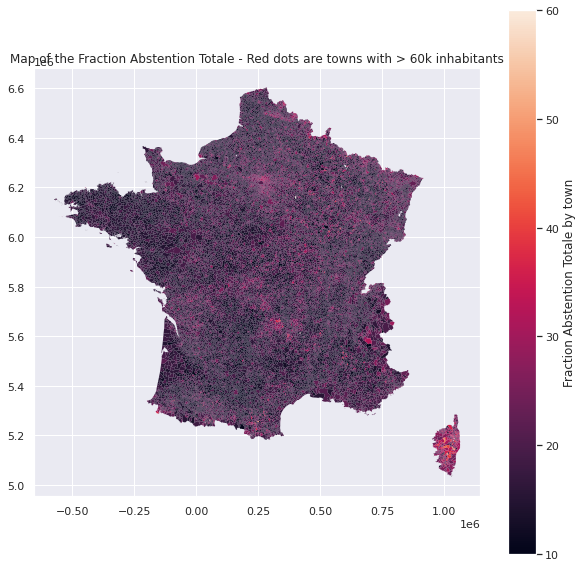

In [16]:
for id in names:
    ax = all_data.plot(
        column=id,figsize=(10,10),edgecolor='none',legend=True,
        legend_kwds={'label': f"{id} by town"},
        vmin=10,vmax=60
    ) 
    plt.title(f"Map of the {id}")
    plt.show()

I noticed in the next section there seems to be a correlation of vote wrt town size, that does not necesseraly pops out on the map. 
Let's try to assess it.

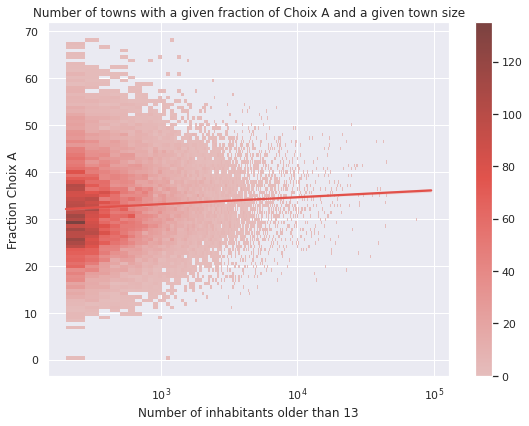

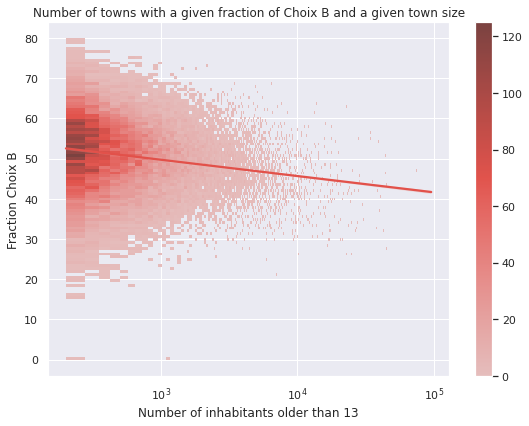

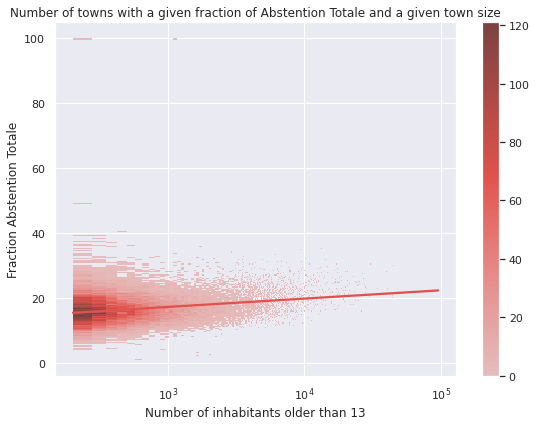

In [17]:
sns.set_palette("Spectral")
cut_pop_data=above200[above200['P13_POP']<100000]
for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.histplot(data=cut_pop_data,x='P13_POP',y=f'Fraction {id}',cbar=True)
    sns.regplot(data=cut_pop_data,x='P13_POP',y=f'Fraction {id}',ax=ax,scatter=False,logx=True)
    plt.xscale('log')
    plt.xlabel('Number of inhabitants older than 13')
    plt.title(f"Number of towns with a given fraction of {id} and a given town size")
    plt.show()

### So it seems fraction of people voting B decreases vs town size, as log(Town Size), while abstention slightly increases and vote A increases.

# III - Check gender & age imbalance

Let's do two things at first :
* Distribution of vote in towns that are mostly male/female
* Scatter plot of fraction of each option vs mean age

This should tell us whether we can make the (unreasonnable) assumption that every age class/gender votes the them in a given town. If it was to be the case we could plot age pyramids easily.

I also compute some weights so that each town is fairly represented in the plot, in every plotting option that supports it (it's not always the case)

In [18]:
above200['MainGender'] = np.where(above200['P13_POPH'] > above200['P13_POPF'], 'Male', 'Female')
above200['weights'] = above200['P13_POP']/above200['P13_POP'].sum()

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


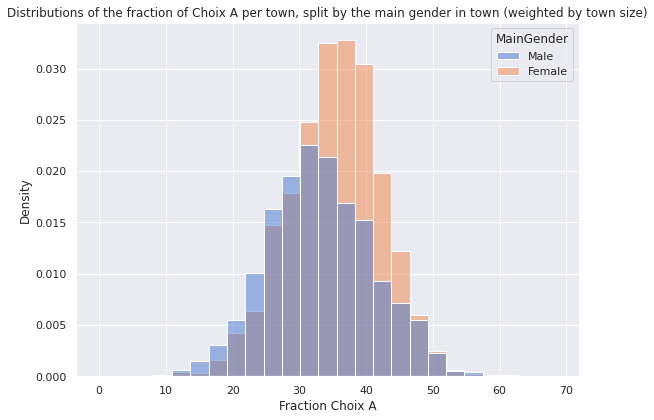

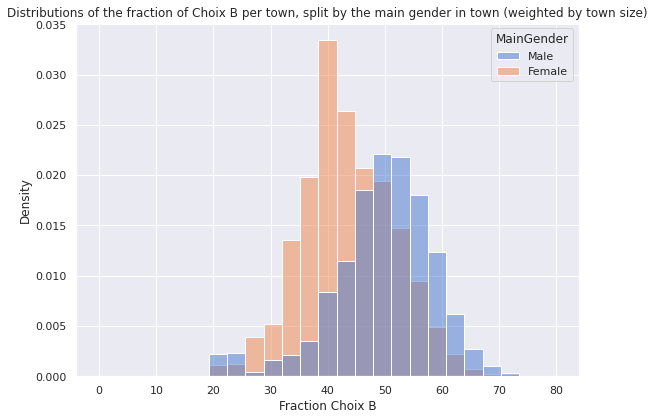

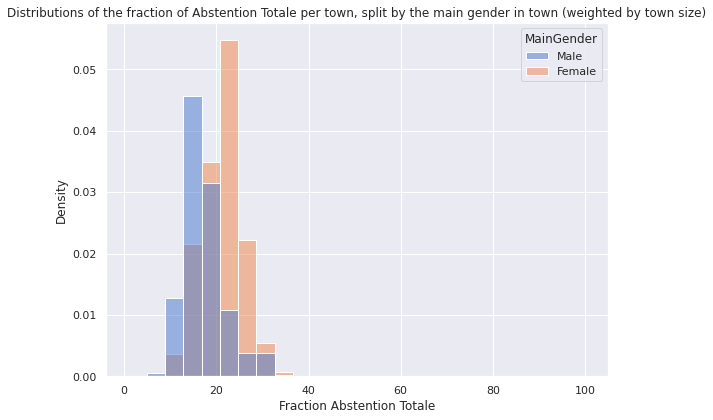

In [19]:
sns.set_palette(sns.color_palette())
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.histplot(data=above200,x=f'Fraction {id}',weights='weights',hue='MainGender',stat='density',palette='muted',bins=25)
    plt.title(f"Distributions of the fraction of {id} per town, split by the main gender in town (weighted by town size)")
    plt.show()

Hidden cells below do the same check with unweighted data. While the conclusion is less dramatic, it still holds.

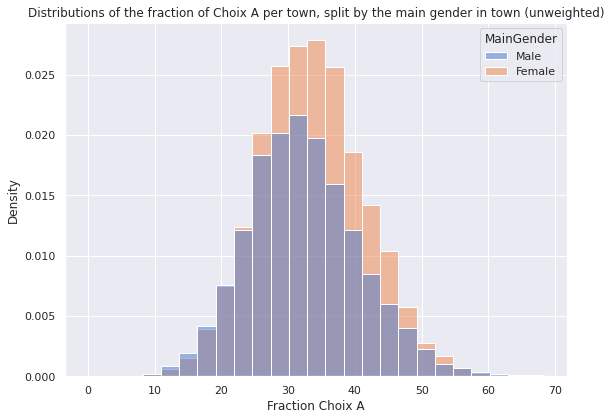

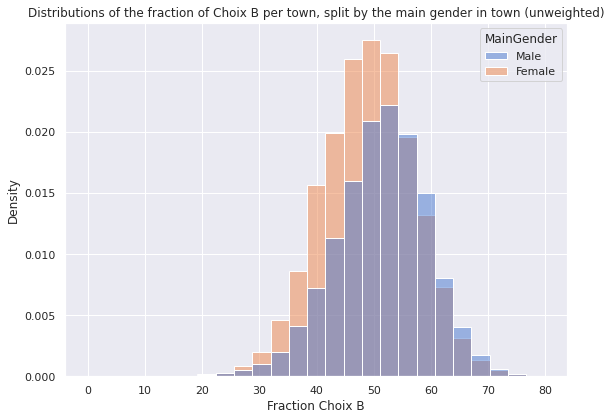

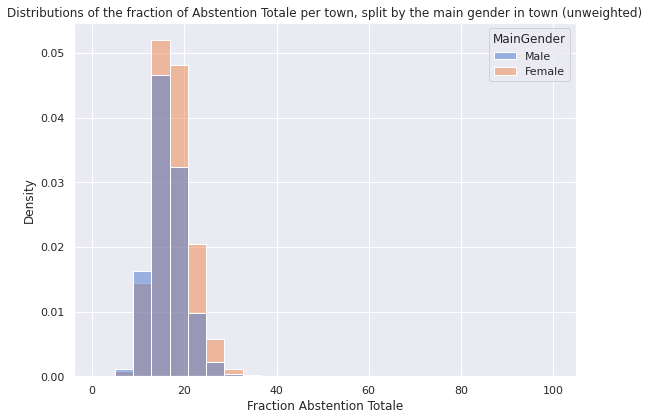

In [20]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.histplot(data=above200,x=f'Fraction {id}',hue='MainGender',stat='density',palette='muted',bins=25)
    plt.title(f"Distributions of the fraction of {id} per town, split by the main gender in town (unweighted)")
    plt.show()

### Towns that are mostly female tend to abstain more, and while Female voters still favor Choice B they are less determined.

Now let's check the correlation wrt age. I will use KDE plots rather than standard scatter plots, as they are too cluttered.
The 2 hidden cells below give the distribution of the fraction of vote vs the mean age in town, for each voting option.

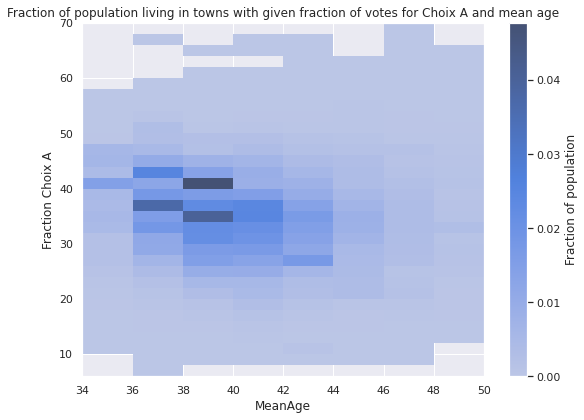

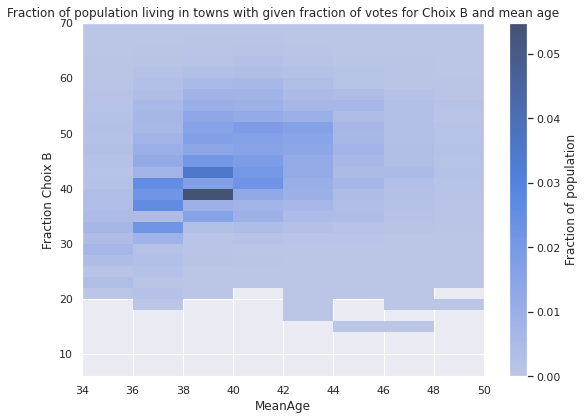

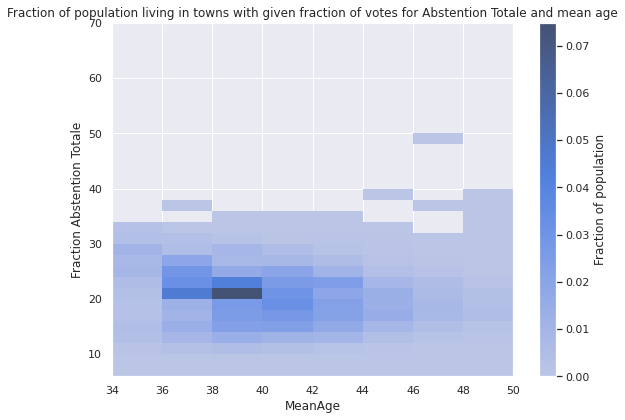

In [59]:
sns.set_palette("muted")

for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.histplot(data=above200,x="MeanAge",y=f'Fraction {id}',weights='weights',bins=(range(34,52,2),range(6,72,2)),cbar=True,cbar_kws={'label': 'Fraction of population'})
    plt.title(f"Fraction of population living in towns with given fraction of votes for {id} and mean age")
    plt.ylim(6,70)
    plt.xlim(34,50)
    plt.show()

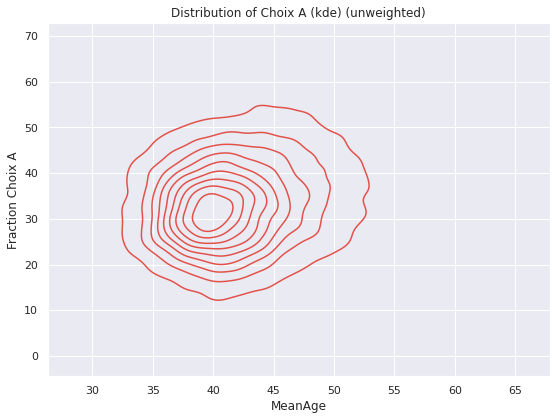

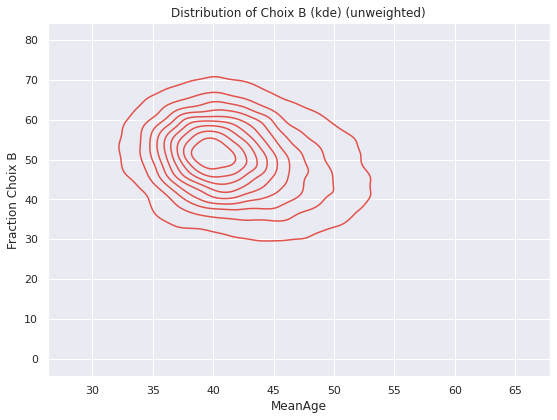

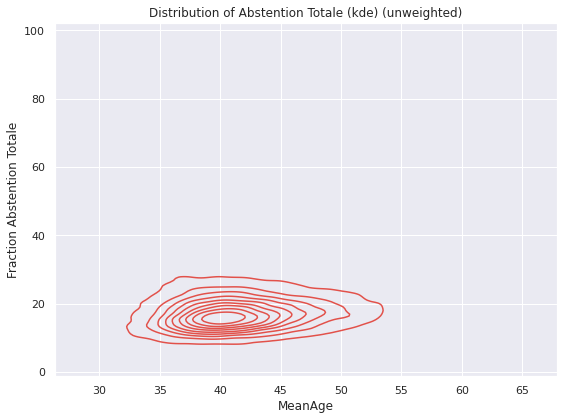

In [22]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.kdeplot(data=above200,y=f'Fraction {id}',x="MeanAge",levels=10)
    plt.title(f"Distribution of {id} (kde) (unweighted)")
    plt.show()

### There seem to be a correlation between age and favoring Choice B, older people being more in favor of it and also voting (slightly) more.

Problem : using the population weights seems to revert the conclusion. Let's check the importance of town size vs mean age.

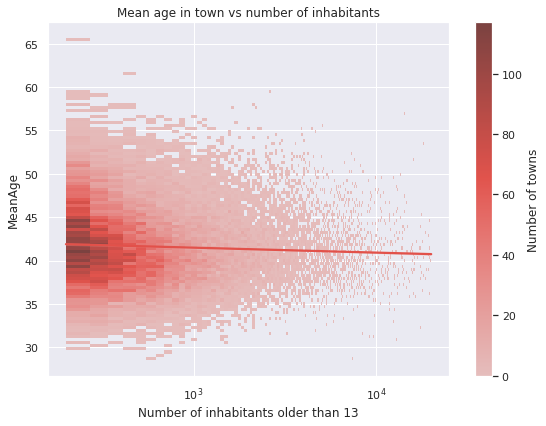

In [23]:
import matplotlib.cm as cm

cut_pop_data=above200[(above200['P13_POP']<20000)]
#population_bins = [20,50,100,150,200,300,400,500,750,1000,1500,2000,3000,4000,5000,7500,10000,15000,20000,25000,50000,100000]
#plt.hist2d(cut_pop_data['P13_POP'], cut_pop_data['MeanAge'], bins=(population_bins,range(30,61,1)), cmap=cm.jet);


ax = sns.histplot(data=cut_pop_data,y="MeanAge",x='P13_POP',cbar=True,cbar_kws={'label': 'Number of towns'})
sns.regplot(ax=ax,data=cut_pop_data,y="MeanAge",x='P13_POP',scatter=False,logx=True)
plt.xscale('log')
plt.xlabel('Number of inhabitants older than 13')
plt.title('Mean age in town vs number of inhabitants')
plt.show()

##### So we see that it is better to keep using these weights otherwise we'll give too much importance to smaller villages that tend to have an older population.
Not including these weights would not give a fair representation of the overall population (although the variation of mean age isn't dramatic)

### Now let's plot the votes distribution by gender.

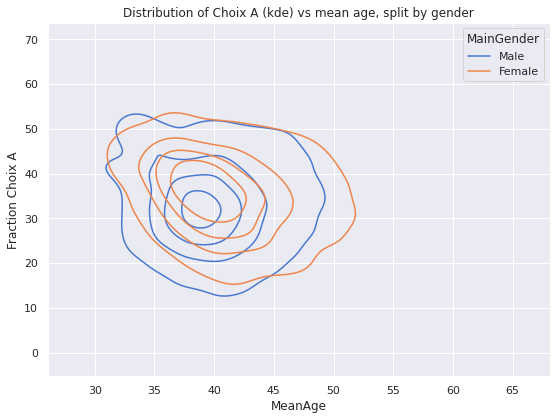

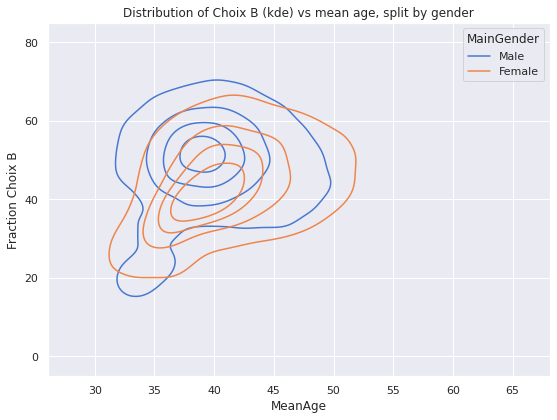

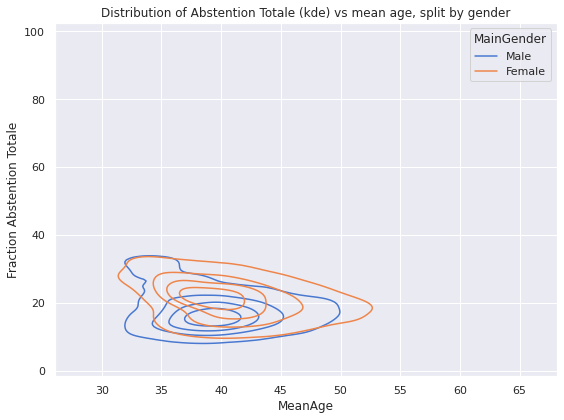

In [61]:
sns.set_palette('muted')
for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.kdeplot(data=above200,y=f'Fraction {id}',x="MeanAge",weights='weights',hue='MainGender',levels=5)
    plt.title(f"Distribution of {id} (kde) vs mean age, split by gender")
    plt.show()

### The correlation we saw between voting B and age seems to be driven by women's vote, older women voting more in favor of A.

I'd have liked to confirm this plot with a scatter/regression plot at a deparmental level to decrease the number of points, but sadly all departments are mostly populated by women (2million more women than men at a national level)

In [25]:
def all_augments(df,helper_df):
    #All augmentations need to be recomputed at the departmental level :
    df['MainGender'] = np.where(df['P13_POPH'] > df['P13_POPF'], 'Male', 'Female')
    df['weights'] = df['P13_POP']/df['P13_POP'].sum()

    df=df.assign(MeanAge=mean_age)
    df=df.assign(MeanDiploma=lambda x: mean_diploma(x,helper_df))
    for id in ["Abstention Totale","Choix A","Choix B"]:
        df[f"Fraction {id}"] = 100*df[id]/dept_data["Inscrits"]
        
    return df

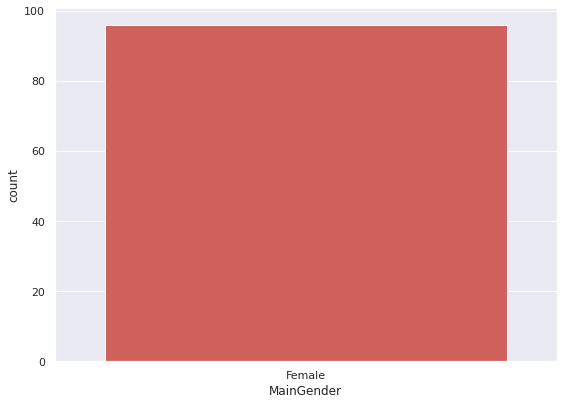

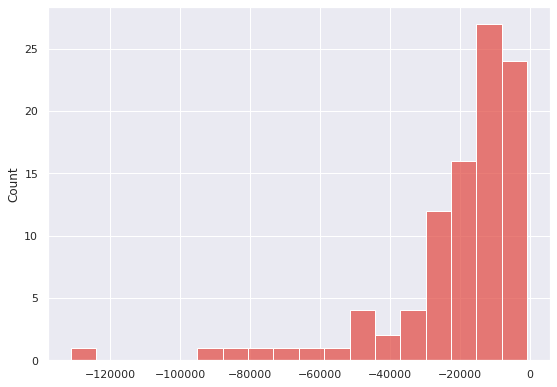

-2009586.065128535


In [26]:
dept_data=above200.groupby('dr').sum()

#All augmentations need to be recomputed at the departmental level :
dept_data=all_augments(dept_data, helper_df)

sns.countplot(data=dept_data,x='MainGender')
plt.show()
sns.histplot(dept_data['P13_POPH']-dept_data['P13_POPF'])
plt.show()
print(dept_data['P13_POPH'].sum()-dept_data['P13_POPF'].sum())

# IV - Correlation with family information : revenues & size

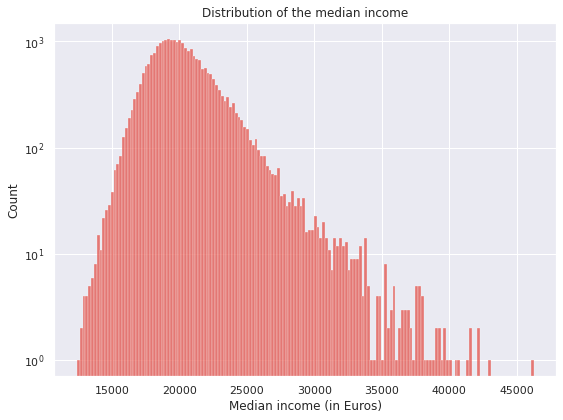

In [27]:
sns.histplot(above200['MED13'])
plt.title("Distribution of the median income")
plt.xlabel("Median income (in Euros)")
plt.yscale('log')

Text(0.5, 1.0, 'Map of the median income per town')

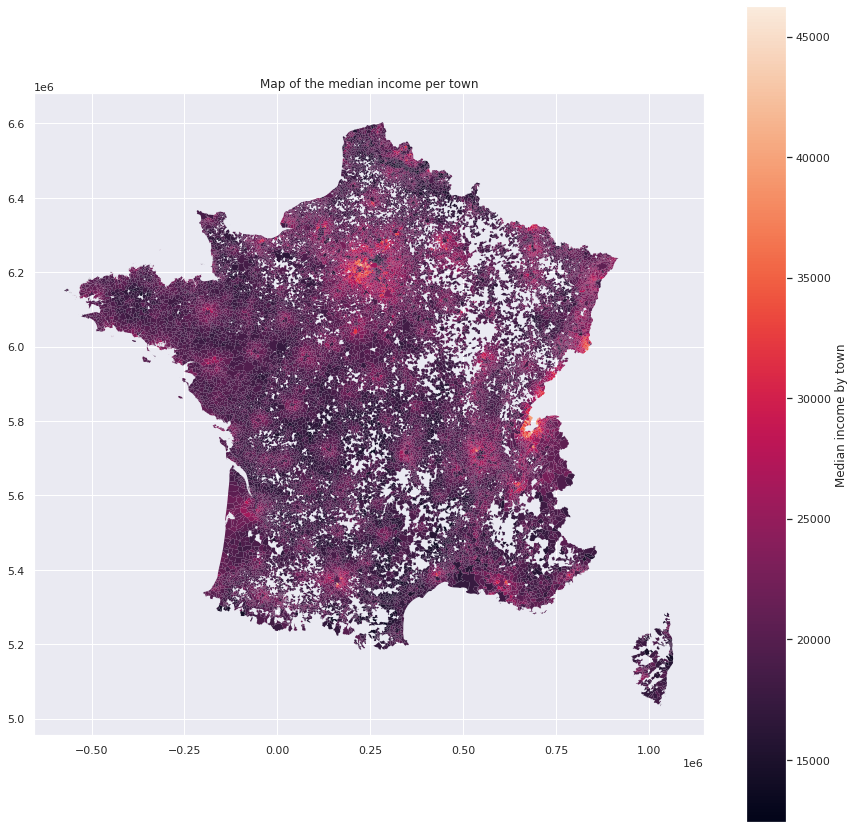

In [28]:
ax = above200.plot(
    column='MED13',figsize=(15,15),edgecolor='none',legend=True,
    legend_kwds={'label': "Median income by town"}
) 
plt.title("Map of the median income per town")

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


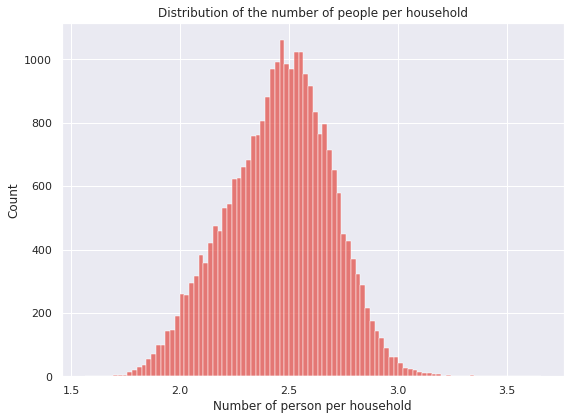

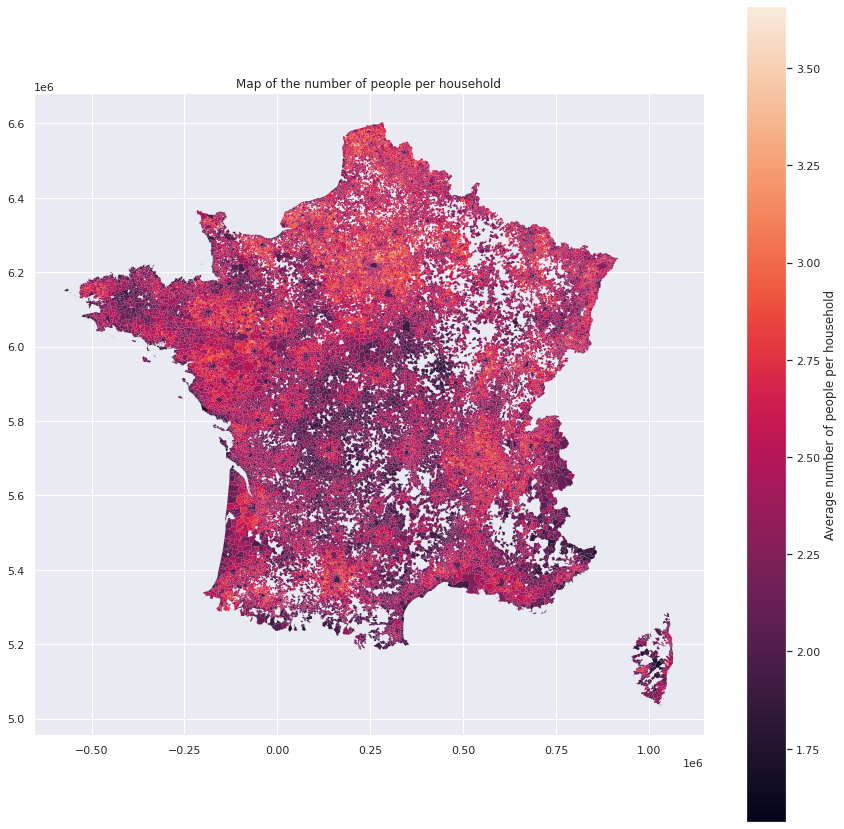

In [29]:
above200["NbFamilyMembers"] = above200["NBPERSMENFISC13"]/above200["NBMENFISC13"]

sns.histplot(data=above200,x="NbFamilyMembers")
plt.title("Distribution of the number of people per household")
plt.xlabel("Number of person per household")
plt.show()

ax = above200.plot(
    column='NbFamilyMembers',figsize=(15,15),edgecolor='none',legend=True,
    legend_kwds={'label': "Average number of people per household"}
) 
plt.title("Map of the number of people per household")
plt.show()

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


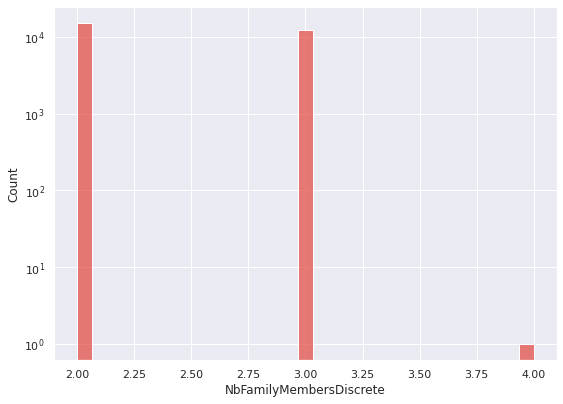

In [30]:
above200["NbFamilyMembersDiscrete"] = np.rint(above200["NbFamilyMembers"])
sns.histplot(data=above200,x="NbFamilyMembersDiscrete")
plt.yscale('log')

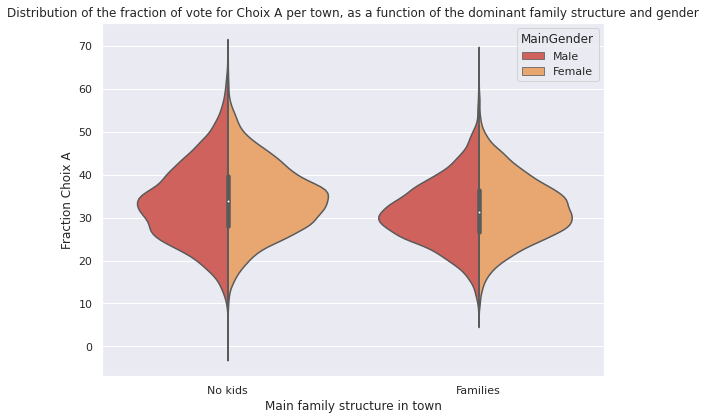

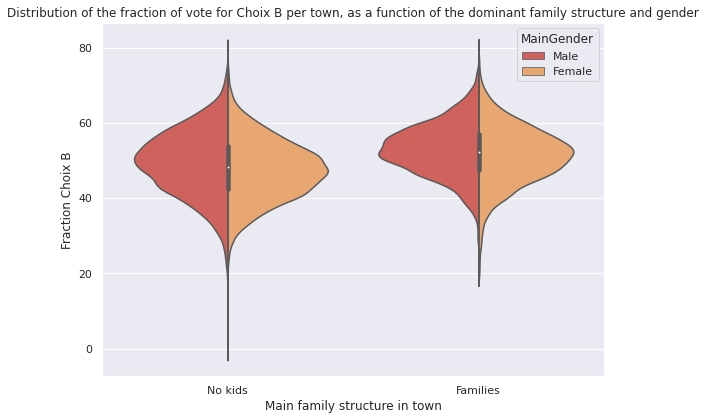

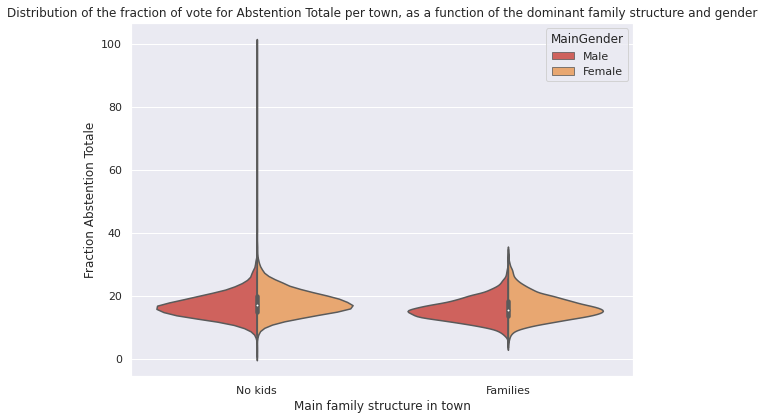

In [31]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.violinplot(data=above200[above200["NbFamilyMembersDiscrete"] != 4],x="NbFamilyMembersDiscrete",y=f"Fraction {id}",hue='MainGender',split=True)
    plt.title(f"Distribution of the fraction of vote for {id} per town, as a function of the dominant family structure and gender")
    plt.xlabel("Main family structure in town")
    plt.xticks([0,1], ["No kids", "Families"])
    plt.show()

### So the difference between the two main types of family structure isn't dramatic. The only thing to point out is that the vote fractions seem to be more picked for families in towns mostly populated by men. 
/!\ Violin plots DO NOT support weights ! /!\

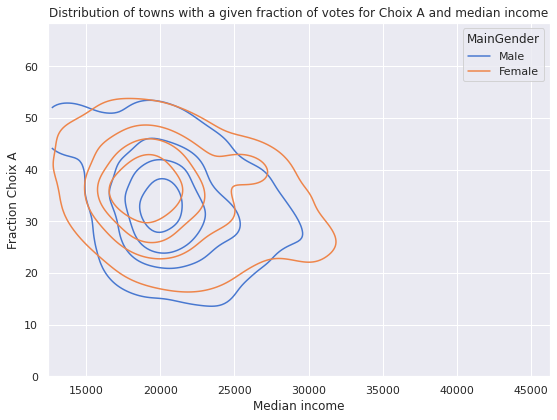

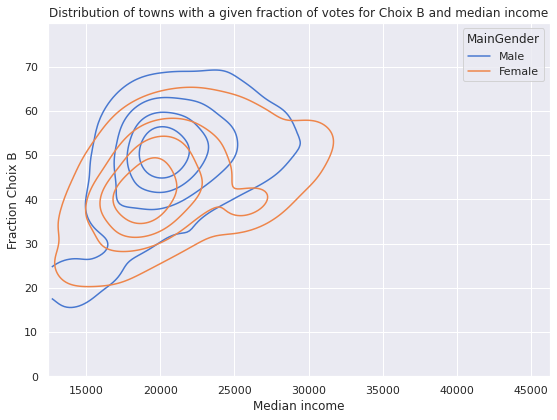

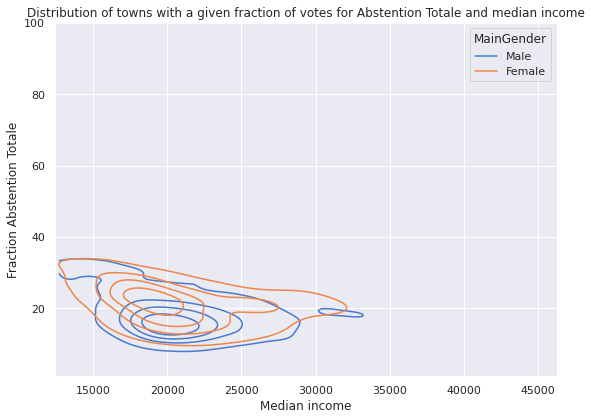

In [60]:
sns.set_palette('muted')

for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.kdeplot(data=above200,x="MED13",y=f'Fraction {id}',weights='weights',hue='MainGender',levels=5,cut=0)
    plt.title(f"Distribution of towns with a given fraction of votes for {id} and median income")
    plt.xlabel('Median income')
    plt.show()

There is a clear correlation between voting B and median income, that is especially strong in towns mostly populated by women.
However this might be the same than the correlation with age seen above. Below we do check that the two aren't so correlated, especially for women.

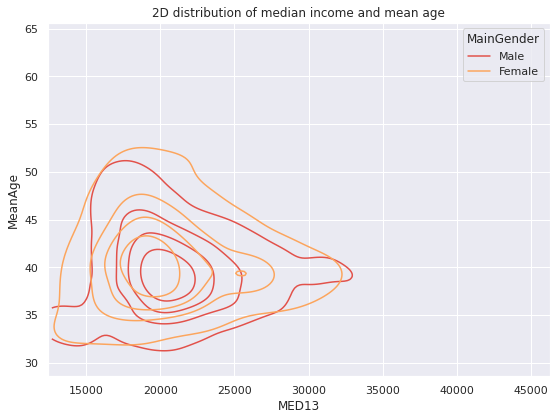

In [33]:
ax=sns.kdeplot(data=above200,x="MED13",y=f'MeanAge',weights='weights',hue='MainGender',levels=5,cut=0)
plt.title(f"2D distribution of median income and mean age")
plt.show()

One last check : wage gap

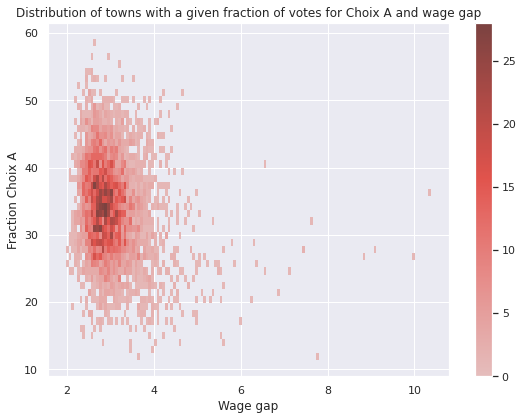

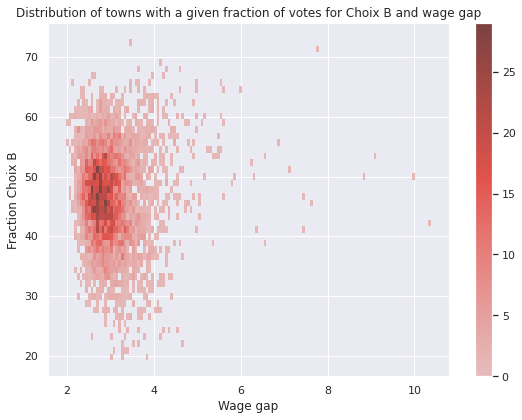

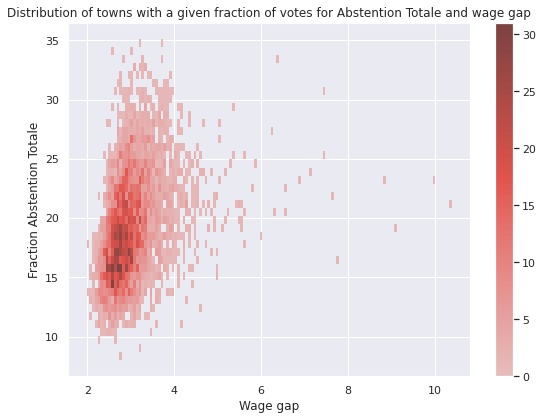

In [56]:
for id in ['Choix A','Choix B','Abstention Totale']:    
    ax=sns.histplot(data=above200,x="RD13",y=f'Fraction {id}',cbar=True)
    plt.title(f"Distribution of towns with a given fraction of votes for {id} and wage gap")
    plt.xlabel('Wage gap')
    plt.show()

Clear correlation between wage gap and abstention

# V - Correlation with level of education

For everything that follows, the Recensement recommends to restrict to towns with > 2000 inhabitants.

Text(0.5, 0, 'Mean education length (in yr)')

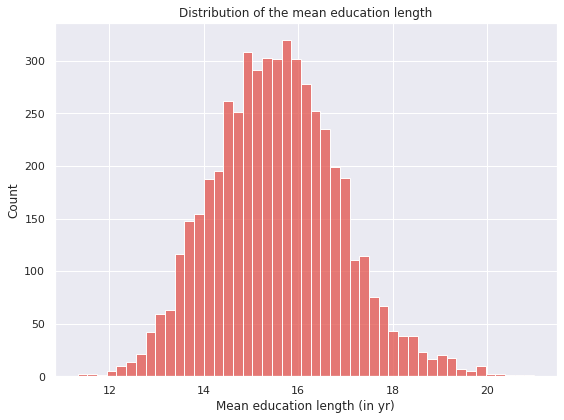

In [34]:
above2000 = above200[above200["P13_POP"]>2000]
sns.histplot(data=above2000,x='MeanDiploma')
plt.title('Distribution of the mean education length')
plt.xlabel('Mean education length (in yr)')

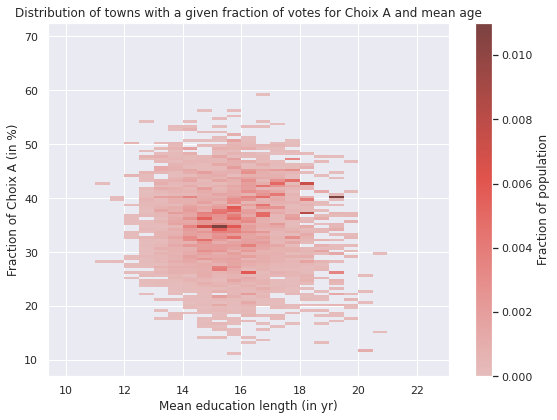

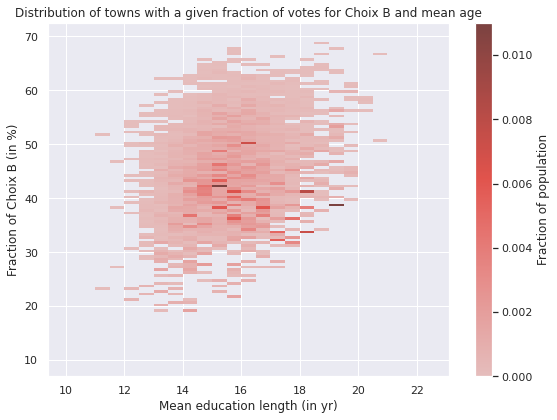

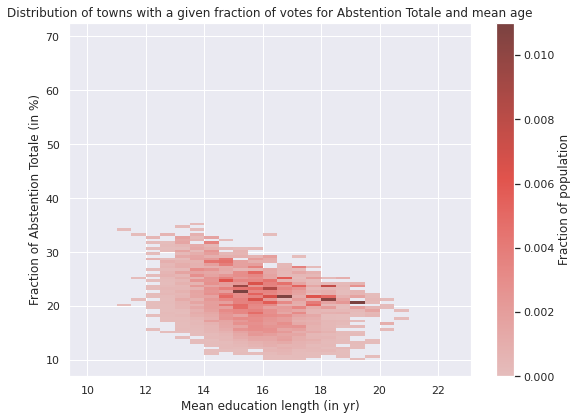

In [35]:
binsX=[id*0.5 for id in range(20,46)]
binsY=[id*0.5 for id in range(20,140)]

for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.histplot(
                    data=above2000,x="MeanDiploma",y=f'Fraction {id}',weights='weights',bins=(binsX,binsY),
                    cbar=True,
                    cbar_kws={'label': 'Fraction of population', 
                             },
                    vmin=0.0,vmax=0.011
                   ) #,cut=0,levels=5)
    plt.title(f"Distribution of towns with a given fraction of votes for {id} and mean age")
    plt.xlabel('Mean education length (in yr)')
    plt.ylabel(f'Fraction of {id} (in %)')
    plt.show()

There seem to be a small correlation with respect to education level, with more educated people voting slightly more and being more in favor of Option A.

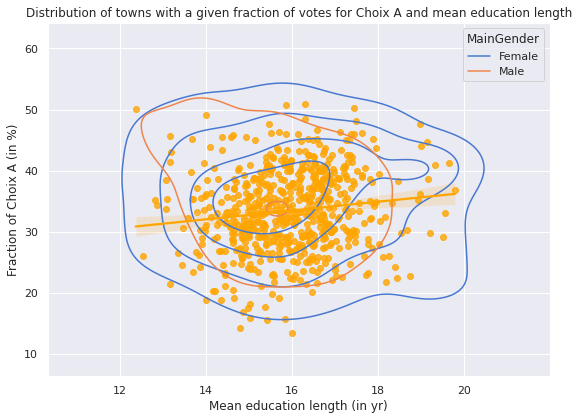

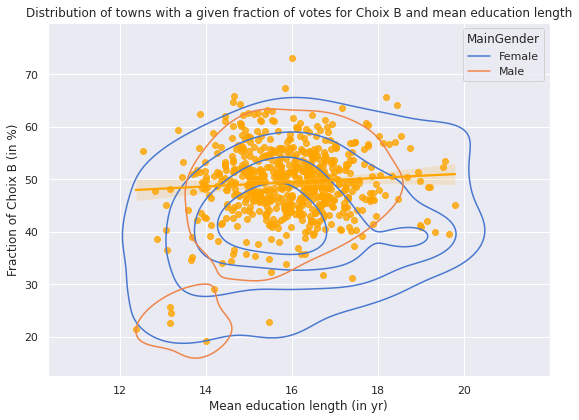

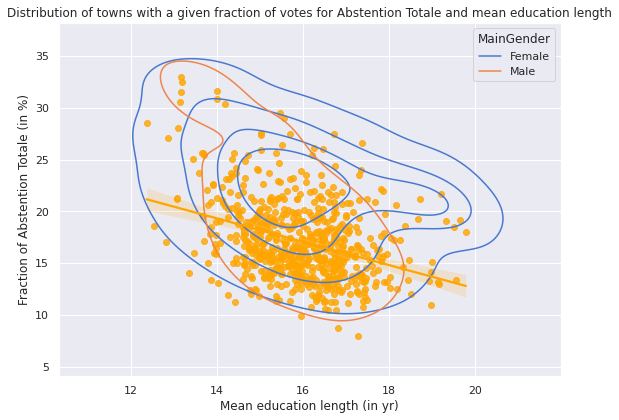

In [62]:
for id in ['Choix A','Choix B','Abstention Totale']:
    ax=sns.kdeplot(
                    data=above2000,x="MeanDiploma",y=f'Fraction {id}',weights='weights',hue='MainGender',levels=5
                   ) #,cut=0,levels=5)
    sns.regplot(ax=ax,data=above2000[above2000['MainGender']=='Male'],x="MeanDiploma",y=f'Fraction {id}',color='orange')
    plt.title(f"Distribution of towns with a given fraction of votes for {id} and mean education length")
    plt.xlabel('Mean education length (in yr)')
    plt.ylabel(f'Fraction of {id} (in %)')
    plt.show()
    

I added the actualpoints (and a regression) for the distribution of the male population, as there is an issue with KDE plot that I do not have the time to dig through (maybe not enough statitics)
/!\ Regplot doesn't support weights /!\

### The main conclusion is that more educated people abstained less, which was expected. There also seem to be a correlation between the level of education and prefering option A although it is weak.

# VI - Impact of social-economical category

In [37]:
above2000["MainSocPro"] = above2000[list(socio_pro_class().keys())].idxmax(axis=1).map(socio_pro_class())

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Categorie socio-professionnelle la plus representee dans chaque ville')

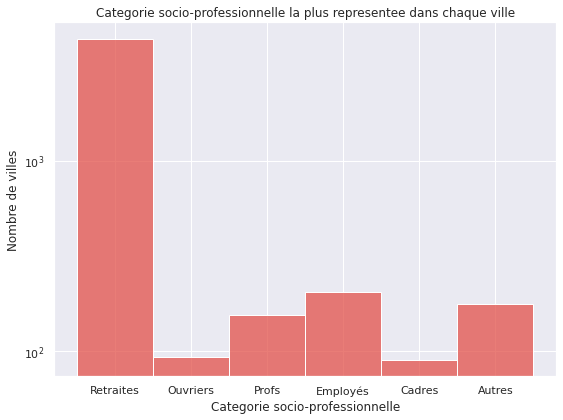

In [46]:
sns.histplot(data=above2000,x='MainSocPro')
plt.xlabel("Categorie socio-professionnelle")
plt.ylabel("Nombre de villes")
plt.yscale('log')
plt.title("Categorie socio-professionnelle la plus representee dans chaque ville")

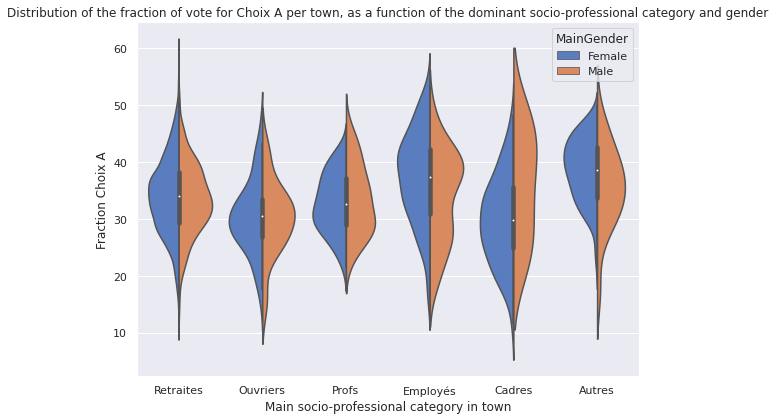

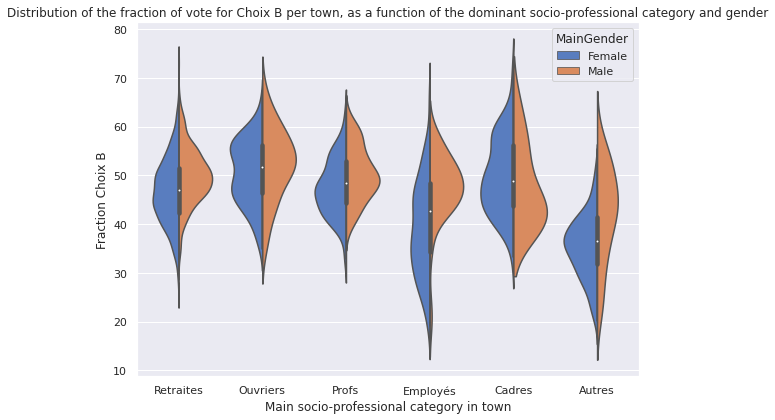

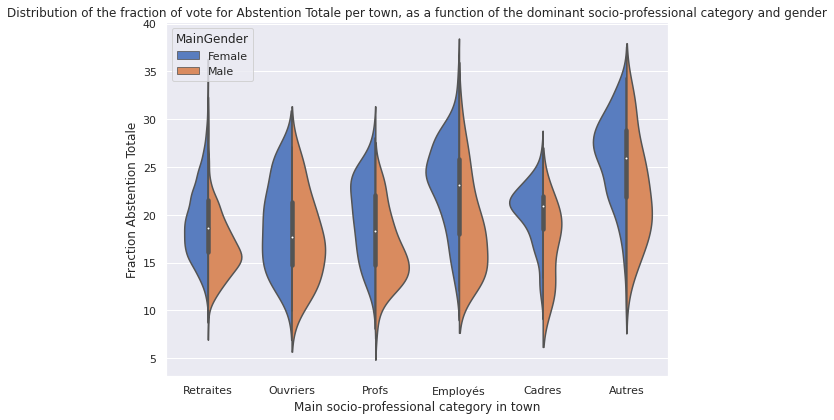

In [63]:
for id in ['Choix A','Choix B','Abstention Totale']:
    sns.violinplot(data=above2000,x="MainSocPro",y=f"Fraction {id}",hue='MainGender',split=True) #,inner='stick')
    plt.title(f"Distribution of the fraction of vote for {id} per town, as a function of the dominant socio-professional category and gender")
    plt.xlabel("Main socio-professional category in town")
    plt.show()

Results for the Male Cadres category in particular have to be taken with a grain of salt, as there isn't enough data.